# Event Detection on WikiHow Website

In this notebook, We extract just a random day of the crawled data, preprocess and extract events using **KMEANS** algorithm. 


For more information about various steps of this notebook you can see the following links:

1. https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a?gi=3ae959754bd9 

2. https://medium.com/@adriensieg/text-similarities-da019229c894 

In [1]:
import os
import random
import string
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

## 1. Data Collection

In [2]:
DATA_PATH = os.path.dirname(os.getcwd())+'/data/processed/trend/'

In [3]:
# extract  a random day of the collected data from preprocessed folder
file = random.choice(os.listdir(DATA_PATH))
df = pd.read_csv(os.path.join(DATA_PATH, file), index_col=0)

In [4]:
df.head()

,date_crawled,title,date_published,date_modified,n_views,n_votes,mean_votes,description,steps
0,2020-03-30,How to Make Hand Sanitizer: 8 Steps (with Pict...,2008-03-09,2020-03-20,"1,970,611",95,91,"\nWashing your hands with soap is better, but ...","[{'@type': 'HowToSection', 'name': 'Alcohol-Ba..."
1,2020-03-30,3 Ways to Play UNO - wikiHow,2007-07-28,2020-03-27,"2,886,397",206,74,\nIf you're looking for a fun card game to pla...,"[{'@type': 'HowToSection', 'name': 'Jumping in..."
2,2020-03-30,3 Easy Ways to Stay Productive While Working f...,2020-03-13,2020-03-26,"6,009",8,95,\nWorking from home offers a wonderful level o...,"[{'@type': 'HowToSection', 'name': 'Organizing..."
3,2020-03-30,How to Make Disinfectant Wipes: 14 Steps (with...,2020-03-12,2020-03-25,"7,736",14,100,\nDisposable disinfecting wipes offer a quick ...,"[{'@type': 'HowToSection', 'name': 'Creating S..."
4,2020-03-30,4 Easy Ways to Take the U.S. Census - wikiHow,2020-03-06,2020-03-23,"7,195",5,100,"\nEvery 10 years, the U.S. government carries ...","[{'@type': 'HowToSection', 'name': 'Responding..."


## 2. Text Preprocessing

In this section we implement the following steps to process text. After that we use _TFIDF_ to extract features. 
1. Tokenize word.
2. Convert upper-case to lower-case.
3. Remove punctuation.
4. Remove non-alphabetic words.
5. Remove stopwords.
6. Stem the words.

__NOTE:__ In **NLTK** library you should download stopwords and punctuation files as follows:

```
>>> import nltk
>>> nltk.download('punkt')
>>> nltk.download('stopwords')
```

In [10]:
def clean_dataframe(df):
    # 0- concat title and description since we use just them 
    df['text'] = df['title'] + df['description']

    # 1. tokenize description and description
    df['text'] = df['text'].apply(word_tokenize)

    # 2- convet upper case to lower case
    df['text'] = df['text'].apply(lambda token: [w.lower() for w in token])

    # 3- remove punctuation
    table = str.maketrans('','', string.punctuation)
    df['text'] = df['text'].apply(lambda token: [w.translate(table) for w in token])

    # 4- remian just alphabet tockens
    df['text'] = df['text'].apply(lambda token: [w for w in token if w.isalpha()])

    # 5- remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update({'make', 'steps', 'step', 'easy', 'ways', 'way', 'wikihow', 'also'})
    df['text'] = df['text'].apply(lambda token: [w for w in token if not w in stop_words]) 

    # 6- Normalize text 
    porter = PorterStemmer()
    df['text'] = df['text'].apply(lambda token: [porter.stem(w) for w in token])

def get_features(df):
    # TFidf identifier
    tfidf = TfidfVectorizer()
    df['text'] = df['text'].apply(lambda token: " ".join(token))
    features_vector = tfidf.fit_transform(df['text'])
    return pd.DataFrame(features_vector.toarray(),
                               columns=tfidf.get_feature_names())

In [12]:
clean_dataframe(df)
features_df = get_features(df)

## 3. Clustering 
In this section first, we use _SILHOUETTE SCORE_ to find the optimal number of the cluster then us _KMEANS_ algorithm to find the clusters.

In [13]:
# choose optimum number of cluser
def get_cluster_number(df):
    score_list = []
    for c in range(2, 6):
        kmeans = KMeans(n_clusters=c, random_state=0).fit(features_df)
        score_list.append((c, silhouette_score(features_df, kmeans.labels_)))
    score_list.sort(key=lambda x: x[1], reverse=True)
    return score_list[0][0]

def get_clusters_words(cls, df):
    cluster_words = []
    for i in range(cls.n_clusters):
        cluster_words.append(' '.join(df.loc[df['class_label']==i, 'text']))
        
    return cluster_words

In [14]:
kmeans = KMeans(n_clusters=get_cluster_number(features_df), random_state=0).fit(features_df)
df['class_label'] = kmeans.labels_

In [15]:
df

,date_crawled,title,date_published,date_modified,n_views,n_votes,mean_votes,description,steps,text,class_label
0,2020-03-30,How to Make Hand Sanitizer: 8 Steps (with Pict...,2008-03-09,2020-03-20,"1,970,611",95,91,"\nWashing your hands with soap is better, but ...","[{'@type': 'HowToSection', 'name': 'Alcohol-Ba...",hand sanit pictur wash hand soap better soap w...,2
1,2020-03-30,3 Ways to Play UNO - wikiHow,2007-07-28,2020-03-27,"2,886,397",206,74,\nIf you're looking for a fun card game to pla...,"[{'@type': 'HowToSection', 'name': 'Jumping in...",play uno look fun card game play friend give u...,1
2,2020-03-30,3 Easy Ways to Stay Productive While Working f...,2020-03-13,2020-03-26,"6,009",8,95,\nWorking from home offers a wonderful level o...,"[{'@type': 'HowToSection', 'name': 'Organizing...",stay product work home work home offer wonder ...,0
3,2020-03-30,How to Make Disinfectant Wipes: 14 Steps (with...,2020-03-12,2020-03-25,"7,736",14,100,\nDisposable disinfecting wipes offer a quick ...,"[{'@type': 'HowToSection', 'name': 'Creating S...",disinfect wipe pictur dispos disinfect wipe of...,2
4,2020-03-30,4 Easy Ways to Take the U.S. Census - wikiHow,2020-03-06,2020-03-23,"7,195",5,100,"\nEvery 10 years, the U.S. government carries ...","[{'@type': 'HowToSection', 'name': 'Responding...",take us censu everi year us govern carri censu...,0
5,2020-03-30,Easy Ways to Disinfect Your Devices: 11 Steps ...,2020-03-16,2020-03-27,"3,431",0,0,\nWith the coronavirus COVID-19 making its way...,"[{'@type': 'HowToSection', 'name': 'Disinfecti...",disinfect devic coronaviru make commun around ...,2


## 4. Visualization

In [16]:
word_clouds = []
for c in range(kmeans.n_clusters):
    words = ' '.join(df[df['class_label']==c]['text'].tolist())
    word_clouds.append(WordCloud(width=600,
                                 height=600,
                                 background_color='white').generate(words))

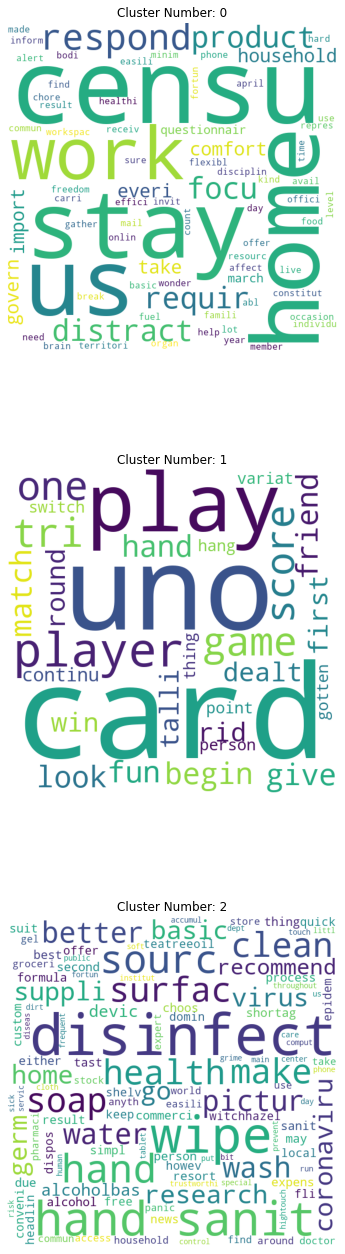

In [17]:
fig, axes = plt.subplots(kmeans.n_clusters, 1, figsize= (20, 20))

for c in range(kmeans.n_clusters):
    axes[c].title.set_text('Cluster Number: %d' %c)
    axes[c].imshow(word_clouds[c]) 
    axes[c].axis("off") 
    fig.tight_layout(pad=10) 

## Trend Detection

In [18]:
def compute_cossine_similarity(c1, c2):
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([c1, c2])
    return cosine_similarity(tfidf_matrix).flatten()[1]
    
def map_clusters(cluster1, cluster2):
    dic = {}
    for i_c1 in range(len(cluster1)):
        for i_c2 in range(len(cluster2)):
            if compute_cossine_similarity(cluster1[i_c1], cluster2[i_c2]) > 0.5:
                if i_c1 in dic:
                    dic[i_c1].append(i_c2)
                else:
                    dic[i_c1]=[i_c2]
    return dic

In [19]:
# sort path based on modification time
paths = sorted(Path(DATA_PATH).iterdir(), key=os.path.getmtime)
previous_clusters_words = []
for file in paths:
    print(str(file).split('/')[-1])
    df = pd.read_csv(file, index_col=0)
    clean_dataframe(df)
    features_df = get_features(df)
    kmeans = KMeans(n_clusters=get_cluster_number(features_df), random_state=0).fit(features_df)
    df['class_label'] = kmeans.labels_
    current_clusters_words = get_clusters_words(kmeans, df)
    if previous_clusters_words:
        print(map_clusters(current_clusters_words, 
                          previous_clusters_words))
    previous_clusters_words = current_clusters_words
    print('=======================================')

2020-03-25.csv
2020-03-26.csv
{}
2020-03-27.csv
{0: [0], 1: [1], 2: [2]}
2020-03-28.csv
{0: [0], 1: [1], 2: [2]}
2020-03-29.csv
{0: [0], 1: [1], 2: [2]}
2020-03-30.csv
{0: [0], 1: [1], 2: [2]}
2020-03-31.csv
{}
2020-04-01.csv
{0: [1], 1: [3]}
